In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [59]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, old_state, action, reward, new_state):
        self.short_memory.append([old_state, action, reward, new_state, False])
        
    def commit(self, final=True): 
        
        self.short_memory[-1][-1] = True
        
# #         discount
#         for i, memo in enumerate(self.short_memory[::-1]):
#             old_state, action, reward, new_state, *_ = memo
            
#             if i == 0:
#                 prev_reward = reward
#                 continue
                
#             reward, prev_reward = prev_reward * 0.99 + reward, reward
#             self.short_memory[len(self.short_memory) - 1 - i][2] = reward 
            
#         self.short_memory = [x for x in self.short_memory if x[-1] == False]
        
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
        else:
            for memo in self.short_memory:
                self.memory.insert(0, memo)
            self.memory = self.memory[:self.capacity]
        
        self.short_memory = []

In [108]:
class Qnet(torch.nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(4, 32),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(32, 2),
#             torch.nn.Sigmoid(),
        #     torch.nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        return self.model(x)

policy_net = Qnet().to(device)
target_net = Qnet().to(device)

target_net.load_state_dict(policy_net.state_dict())

optim = torch.optim.Adam(policy_net.parameters(), lr=0.01)

from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optim, step_size=30, gamma=0.96)    

In [112]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 2000

EPS = 0.8
EPS_MIN = 0.05
GAMMA = 0.999


def get_model_action(model, state, device, train=True):
    global EPS, EPS_MIN, GAMMA
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    if not train or random.random() > EPS:
        with torch.no_grad():
            model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
            action = np.argmax(model_output[0])
    else:
        action = random.randint(0, 1)
    return action

def train(model, memory, device):
    memory = memory.memory
    np.random.shuffle(memory)
    memory = memory[:32]

    s0 = [x[0] for x in memory]
    a = [x[1] for x in memory]
    r = [x[2] for x in memory]
    s1 = [x[3] for x in memory]
    done = [1. if x[4] else 0. for x in memory]


    s0 = torch.FloatTensor(s0).to(device)
    s1 = torch.FloatTensor(s1).to(device)
    a = torch.LongTensor(a).to(device)
    r = torch.FloatTensor(r).to(device)
    done = torch.FloatTensor(done).to(device)


    q_values = policy_net(s0)
    next_q_values = policy_net(s1)
    next_q_value = next_q_values.max(1)[0]

    q_value = q_values.gather(1, a.unsqueeze(1)).squeeze(1)
    expected_q_value = r + 0.999 * next_q_value * (1 - done)
    # Notice that detach the expected_q_value
    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

        
#     scheduler.step()

memory = Memory(capacity=1000)  
len_mem = []

try:
    for episode in range(100000):
        state = env.reset()

        for i in count():
#             env.render()

            action = get_model_action(policy_net, state, device)
            old_state = state
            state, reward, done, info = env.step(action)
            
            memory.push(old_state, action, reward, state)
            state = old_state

            if done:
                env.close()
                len_mem.append(i)
                memory.commit()
                break

        
        if episode % 100 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-50:]), EPS))
        
        train(policy_net, memory, device)
        
        if episode % 3 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
    
except KeyboardInterrupt:
    env.close()

Episode   0:     23.000 iterations, eps=0.781019
32.270652770996094
663.281494140625
599.9697875976562
337.6416015625
293.78363037109375
471.4775085449219
243.86557006835938
612.4090576171875
453.6369323730469
428.3853454589844
578.6228637695312
280.8193359375
763.8723754882812
520.3828125
518.5515747070312
461.82061767578125
329.4729919433594
734.88525390625
233.59930419921875
285.6983642578125
439.68304443359375
724.92822265625
750.1766357421875
476.31402587890625
126.51092529296875
571.7223510742188
388.7974853515625
193.38433837890625
715.9907836914062
326.44744873046875
442.72882080078125
527.687744140625
523.1528930664062
733.76806640625
629.16552734375
407.08984375
324.59063720703125
515.3700561523438
236.1522216796875
295.863525390625
231.68167114257812
592.4804077148438
260.1166076660156
305.27386474609375
467.6983642578125
137.64013671875
291.91754150390625
168.10345458984375
485.8853759765625
703.451904296875
381.7781677246094
237.01699829101562
201.2368927001953
277.7528381

495.54327392578125
490.81890869140625
469.9854736328125
228.0842742919922
205.37879943847656
363.0601501464844
287.3003234863281
437.9678039550781
279.09039306640625
303.9266662597656
169.5763702392578
461.33685302734375
333.9499206542969
116.65261840820312
169.17391967773438
260.335693359375
324.58319091796875
160.404541015625
176.5426788330078
206.6894989013672
525.7514038085938
272.28680419921875
276.50701904296875
262.52593994140625
388.6615905761719
339.9672546386719
408.97198486328125
175.95008850097656
456.0643615722656
219.33926391601562
290.5473327636719
267.5436096191406
308.88531494140625
174.54135131835938
142.740478515625
153.7587127685547
229.0963134765625
149.8877410888672
186.32655334472656
188.7476043701172
297.45721435546875
84.22555541992188
193.62762451171875
306.17706298828125
393.86785888671875
86.23271942138672
38.10017776489258
210.96682739257812
260.7233581542969
203.70999145507812
Episode 500:      8.400 iterations, eps=0.050000
123.29425811767578
207.95101928

333.4789733886719
48.82184600830078
276.00823974609375
167.9962921142578
156.03579711914062
210.926025390625
192.04800415039062
94.61289978027344
69.29827117919922
118.93003845214844
222.0292510986328
131.59295654296875
243.5882568359375
147.54603576660156
141.51422119140625
207.25265502929688
163.7718963623047
164.5144805908203
273.3278503417969
31.635814666748047
135.79476928710938
218.281982421875
147.10231018066406
253.21011352539062
31.698482513427734
296.5929260253906
179.6182403564453
119.12008666992188
280.7587890625
126.74850463867188
174.16603088378906
115.44538879394531
296.2837219238281
118.73043060302734
236.76292419433594
229.77481079101562
225.006103515625
198.19305419921875
159.70143127441406
194.8299560546875
204.5474090576172
180.7083740234375
209.4072265625
176.01222229003906
173.16722106933594
170.01400756835938
Episode 1000:      8.600 iterations, eps=0.050000
212.53280639648438
179.7364044189453
382.163818359375
224.540771484375
135.28504943847656
168.893569946289

159.81069946289062
175.6316680908203
90.38886260986328
168.81964111328125
176.4721221923828
198.85523986816406
177.2688446044922
284.37359619140625
233.78550720214844
151.44091796875
161.83941650390625
213.83140563964844
104.93736267089844
222.33328247070312
212.21115112304688
136.56423950195312
165.2789764404297
77.43708801269531
151.36134338378906
404.47955322265625
114.26681518554688
161.25143432617188
271.89642333984375
209.5025177001953
188.0177001953125
35.35476303100586
335.4581298828125
263.3831787109375
156.73606872558594
206.33470153808594
320.1060791015625
316.0024108886719
197.7308807373047
167.57350158691406
214.14100646972656
204.16976928710938
298.9894104003906
569.3511352539062
263.7303771972656
95.91525268554688
375.457763671875
237.5595703125
115.14104461669922
470.9000549316406
281.7801208496094
270.07098388671875
409.0284423828125
477.1184997558594
248.78280639648438
394.7714538574219
130.08921813964844
Episode 1500:      8.540 iterations, eps=0.050000
340.433044433

244.3924102783203
238.52999877929688
198.36158752441406
117.462158203125
109.68071746826172
25.56479263305664
160.81883239746094
79.04823303222656
176.76109313964844
190.69488525390625
129.36648559570312
79.28987884521484
106.36997985839844
236.41818237304688
116.01438903808594
71.89615631103516
122.8027114868164
233.83251953125
209.5709228515625
149.88037109375
211.8389129638672
94.22640991210938
74.87751007080078
25.38202476501465
180.6014404296875
105.99967193603516
86.40625762939453
250.27255249023438
107.98321533203125
180.70755004882812
75.66040802001953
171.806884765625
202.24867248535156
200.90335083007812
93.72675323486328
288.2493591308594
120.52470397949219
194.29876708984375
308.24627685546875
108.50115966796875
185.84739685058594
234.37535095214844
231.99839782714844
150.99539184570312
77.61112213134766
61.93462371826172
108.7707290649414
123.63787078857422
43.92776870727539
230.02603149414062
101.15098571777344
233.7555389404297
50.40217590332031
283.9864501953125
185.562

49.01008987426758
31.505584716796875
61.754371643066406
32.43525695800781
41.921173095703125
56.61415481567383
86.31884765625
89.1715316772461
91.99114990234375
47.41374969482422
41.86542510986328
54.38991165161133
54.65528106689453
83.05867004394531
84.04094696044922
24.420955657958984
11.4043550491333
80.06538391113281
45.375728607177734
89.89340209960938
25.061344146728516
74.40646362304688
49.60428237915039
54.10636901855469
28.979650497436523
19.566286087036133
71.627685546875
Episode 2400:      8.500 iterations, eps=0.050000
46.6286735534668
87.33985900878906
57.74957275390625
65.89122009277344
64.82110595703125
10.497276306152344
57.319114685058594
109.80683135986328
139.0636444091797
59.16331481933594
26.858535766601562
35.63807678222656
89.00265502929688
69.89910125732422
77.2065200805664
76.07998657226562
23.600658416748047
96.15241241455078
23.47788429260254
56.3853645324707
64.37356567382812
95.59009552001953
99.57902526855469
48.83184814453125
31.923404693603516
73.3214263

71.46885681152344
70.69908142089844
116.29997253417969
133.39283752441406
98.01582336425781
82.87975311279297
129.46363830566406
124.14546203613281
127.57913208007812
69.6506118774414
145.80775451660156
63.7336540222168
91.10926818847656
90.6114501953125
122.05899047851562
52.417911529541016
134.84991455078125
64.46573638916016
104.54216766357422
21.838909149169922
103.16195678710938
75.89958190917969
174.95803833007812
146.01492309570312
118.25855255126953
54.09476089477539
75.4613265991211
53.99833679199219
149.1168975830078
140.40240478515625
54.247962951660156
43.435157775878906
235.77801513671875
38.038169860839844
93.75294494628906
126.78070068359375
195.64622497558594
77.98869323730469
111.9913101196289
131.91400146484375
20.676456451416016
66.1005859375
15.050093650817871
101.27607727050781
124.04554748535156
129.6840057373047
67.41767883300781
150.6296844482422
107.69983673095703
99.54652404785156
89.58612060546875
102.34104919433594
128.03433227539062
82.29158020019531
89.899

Episode 3300:      8.440 iterations, eps=0.050000
304.4760437011719
314.5852355957031
409.19720458984375
467.213623046875
379.5721435546875
276.392822265625
361.96563720703125
726.1590576171875
707.2992553710938
551.6564331054688
437.8680114746094
23.531219482421875
365.6962890625
113.52457427978516
255.74530029296875
334.72845458984375
97.93093872070312
509.29754638671875
455.2275695800781
197.34214782714844
357.6772766113281
222.68121337890625
214.4520263671875
275.4821472167969
126.29061889648438
76.77134704589844
167.7894287109375
33.21070098876953
163.3909149169922
76.7420654296875
137.86180114746094
289.3386535644531
229.08038330078125
185.1509552001953
27.059062957763672
135.85980224609375
182.81707763671875
50.55927276611328
154.80279541015625
405.72454833984375
159.39404296875
143.55686950683594
132.73828125
110.25308990478516
296.84130859375
19.920879364013672
248.9515380859375
213.97084045410156
158.80946350097656
152.50439453125
136.4645538330078
145.25465393066406
88.24459

28.052288055419922
58.836448669433594
65.37779998779297
79.4526596069336
25.83881378173828
28.985380172729492
35.212730407714844
34.569881439208984
42.1039924621582
35.98674392700195
48.05769348144531
30.04511260986328
28.216604232788086
11.269463539123535
39.64397048950195
19.970720291137695
22.610031127929688
27.46297836303711
32.932247161865234
20.68115234375
25.923873901367188
21.224353790283203
23.217798233032227
23.41609764099121
17.549068450927734
24.403932571411133
36.525028228759766
22.163349151611328
38.9868049621582
78.09905242919922
55.07396697998047
40.06242370605469
38.115867614746094
40.80901336669922
9.745922088623047
30.146636962890625
18.230052947998047
31.667299270629883
11.053475379943848
40.46458435058594
31.165924072265625
41.91217041015625
30.97141456604004
9.619440078735352
25.665985107421875
50.10370635986328
31.946439743041992
20.42804718017578
18.59549903869629
30.151424407958984
41.492759704589844
34.41048049926758
20.325136184692383
42.516990661621094
28.78

191.46897888183594
321.2544860839844
173.87356567382812
196.84324645996094
282.62554931640625
392.2915344238281
273.519775390625
134.5362091064453
116.58368682861328
558.4879150390625
146.41744995117188
287.6885681152344
299.8207702636719
185.16383361816406
276.6087341308594
302.92376708984375
336.4110412597656
340.200439453125
256.2271423339844
65.12899780273438
199.8006591796875
285.9953918457031
222.56787109375
233.00701904296875
438.6002502441406
447.1365966796875
493.0443115234375
304.7973937988281
544.5606689453125
532.485107421875
83.55715942382812
668.0618896484375
712.828125
662.8866577148438
561.094970703125
446.9695129394531
493.96514892578125
371.3857116699219
440.3600769042969
369.810546875
265.2408142089844
497.8847961425781
305.3896789550781
426.20587158203125
430.9190979003906
283.32293701171875
650.5903930664062
539.4089965820312
827.15234375
483.1253967285156
959.088134765625
1034.2799072265625
627.7180786132812
553.2728271484375
506.46502685546875
295.95263671875
819

111921831936.0
206045364224.0
187130707968.0
230811811840.0
226313256960.0
206479343616.0
292688822272.0
216304140288.0
332190121984.0
274226921472.0
199656013824.0
263765032960.0
138877861888.0
169571467264.0
333599735808.0
378563690496.0
250983088128.0
183848222720.0
154508541952.0
343118708736.0
224407764992.0
226346516480.0
413339320320.0
189863804928.0
269115408384.0
136113004544.0
253344776192.0
301149618176.0
284190375936.0
280984092672.0
417952268288.0
445404545024.0
182985867264.0
365196410880.0
417935654912.0
365284622336.0
404000243712.0
218748895232.0
183089430528.0
277740027904.0
573087285248.0
403209781248.0
265847504896.0
428679823360.0
218439974912.0
355648503808.0
527366520832.0
285765959680.0
489565356032.0
286502027264.0
229888442368.0
499211632640.0
354422554624.0
359172276224.0
294349733888.0
604187852800.0
136939520000.0
372836302848.0
473271402496.0
428880560128.0
471183294464.0
321555234816.0
211650641920.0
548678008832.0
561983258624.0
310770040832.0
2546415861

186932051968.0
200829632512.0
188549808128.0
262223855616.0
183376478208.0
183980310528.0
270298857472.0
188216737792.0
349018128384.0
271610544128.0
185756844032.0
270175043584.0
344068751360.0
113330946048.0
508741582848.0
325623808000.0
28196337664.0
26019475456.0
187082260480.0
187644641280.0
268804685824.0
347128463360.0
265774727168.0
423501922304.0
403801899008.0
271041609728.0
269195460608.0
338517819392.0
437105426432.0
83766648832.0
351795806208.0
180099514368.0
668506587136.0
321896808448.0
101448794112.0
25843791872.0
266149396480.0
109033095168.0
262380044288.0
103208435712.0
265688612864.0
398869069824.0
106854014976.0
341676261376.0
109047635968.0
106485448704.0
426513989632.0
349103030272.0
256769032192.0
101993168896.0
184515969024.0
231069417472.0
181479063552.0
186533756928.0
343201021952.0
184932122624.0
262635700224.0
184417124352.0
254026973184.0
337092182016.0
99522658304.0
264885551104.0
99327762432.0
271372238848.0
188294938624.0
112377880576.0
344324636672.0
1

118383132672.0
82335031296.0
84473135104.0
225097531392.0
118192734208.0
111419064320.0
47726288896.0
156156952576.0
113858150400.0
50777751552.0
48940072960.0
118949322752.0
115618127872.0
196343988224.0
120734318592.0
226529198080.0
Episode 6100:      8.780 iterations, eps=0.050000
161149812736.0
85511815168.0
155716681728.0
116318511104.0
83290611712.0
128318619648.0
84788592640.0
191425789952.0
78984052736.0
13150978048.0
117786451968.0
187204419584.0
119875829760.0
157303619584.0
118231826432.0
117364989952.0
119014031360.0
116972224512.0
219115470848.0
82520178688.0
256733052928.0
154368212992.0
228363223040.0
125147316224.0
13995108352.0
45134295040.0
116228440064.0
186123911168.0
84546273280.0
109835919360.0
84350296064.0
222669701120.0
153894748160.0
155708588032.0
151393681408.0
84822548480.0
87102128128.0
151593074688.0
294754746368.0
150721904640.0
194370863104.0
156628418560.0
117124276224.0
123099561984.0
218052673536.0
121380823040.0
218504937472.0
82716737536.0
15333159

160700186624.0
123648401408.0
336699555840.0
113743192064.0
255025987584.0
251952021504.0
169325641728.0
165579571200.0
74442186752.0
107973664768.0
160013778944.0
Episode 6700:      8.720 iterations, eps=0.050000
200676016128.0
123448303616.0
211499073536.0
113925931008.0
252167421952.0
119060422656.0
250724958208.0
118724083712.0
263145160704.0
240614260736.0
75403214848.0
156740141056.0
208929243136.0
207939207168.0
78049820672.0
121043296256.0
212875952128.0
255633195008.0
300158058496.0
162299428864.0
208303030272.0
28883718144.0
161005289472.0
110642610176.0
72341839872.0
24009187328.0
159862521856.0
163793649664.0
312290508800.0
116520116224.0
252987326464.0
259868114944.0
251937144832.0
218514145280.0
249724928000.0
168872443904.0
117654528000.0
119491174400.0
214911582208.0
257083523072.0
162913353728.0
213013331968.0
206806990848.0
119034626048.0
293616189440.0
69155651584.0
71270178816.0
253384032256.0
23132485632.0
113265524736.0
164770873344.0
214933454848.0
214091366400.0

147238092800.0
86424412160.0
137087287296.0
33819328512.0
109636591616.0
85074984960.0
87276748800.0
61127483392.0
89979682816.0
84176216064.0
140551749632.0
108964282368.0
139230248960.0
166243368960.0
109363978240.0
83457105920.0
53155799040.0
60155252736.0
55491596288.0
58108219392.0
136392900608.0
84774838272.0
84391600128.0
108150775808.0
54199599104.0
3564989440.0
107973623808.0
84248526848.0
82618753024.0
56258424832.0
110496137216.0
84775583744.0
54519816192.0
131775299584.0
58185125888.0
54969167872.0
183224041472.0
106017562624.0
106801692672.0
3796506624.0
53311500288.0
26877810688.0
107729477632.0
54676541440.0
54957133824.0
132852703232.0
79968796672.0
58886307840.0
30780497920.0
29638031360.0
130593497088.0
52427661312.0
158225072128.0
119572291584.0
128283475968.0
97499594752.0
51678806016.0
83438977024.0
54963965952.0
26314670080.0
Episode 7300:      8.820 iterations, eps=0.050000
49727528960.0
74380230656.0
77153107968.0
3230708224.0
50898665472.0
79953379328.0
5261478

33360191488.0
67370287104.0
43735126016.0
46108213248.0
2296679936.0
44630134784.0
11587687424.0
31959443456.0
12727461888.0
22242650112.0
23635810304.0
24296239104.0
25771024384.0
53604171776.0
71046733824.0
23699068928.0
23337601024.0
46105796608.0
33460498432.0
34608570368.0
2344132352.0
44273328128.0
68533760000.0
45367463936.0
12560633856.0
75593531392.0
54631882752.0
12906506240.0
25463488512.0
45505130496.0
54856781824.0
22600712192.0
42398515200.0
45797502976.0
54742929408.0
21210202112.0
24321054720.0
43802284032.0
21634461696.0
22248282112.0
12768754688.0
66397175808.0
42169835520.0
11700512768.0
23539843072.0
34805788672.0
13201758208.0
32737622016.0
33739610112.0
65737588736.0
42952925184.0
52598341632.0
33434826752.0
13852819456.0
31324213248.0
1754319744.0
116639547392.0
22102075392.0
33687019520.0
34824384512.0
34741600256.0
31262058496.0
21249052672.0
54040379392.0
32751413248.0
32821321728.0
12046992384.0
11282533376.0
34342219776.0
41786269696.0
11795668992.0
44877668

30855538688.0
31533858816.0
33186613248.0
32459896832.0
25546518528.0
6309372416.0
9853616128.0
15705647104.0
11400731648.0
11667445760.0
32715073536.0
10756418560.0
21092265984.0
16289394688.0
15938846720.0
15841755136.0
5247811072.0
35958738944.0
11131996160.0
16263748608.0
26262278144.0
20872486912.0
15245569024.0
26990448640.0
20642043904.0
6300009472.0
16120684544.0
19712698368.0
6193408000.0
9848562688.0
31148490752.0
619691392.0
15265616896.0
5372443648.0
31564234752.0
25865906176.0
15544175616.0
26650877952.0
14682317824.0
21035245568.0
24743837696.0
10286955520.0
5891462144.0
20526469120.0
19920265216.0
20659767296.0
24914925568.0
11132922880.0
25842706432.0
16509213696.0
10348549120.0
20764338176.0
16151397376.0
19517671424.0
16253770752.0
5672022016.0
24895848448.0
26228883456.0
14634015744.0
13738519552.0
10449391616.0
24251281408.0
24896905216.0
29403144192.0
9136150528.0
Episode 8500:      8.480 iterations, eps=0.050000
9970820096.0
24190924800.0
18886715392.0
21305747456

6563768320.0
9768352768.0
4041851136.0
13371212800.0
13254514688.0
7244977152.0
16127167488.0
24850810880.0
875277888.0
15077542912.0
21546534912.0
17946376192.0
13134325760.0
12502610944.0
6979997184.0
10194712576.0
6850289152.0
6967770112.0
20535554048.0
19384182784.0
13105193984.0
15324136448.0
7048062464.0
9724662784.0
17704308736.0
6179052544.0
9322835968.0
6835977216.0
12871313408.0
13112691712.0
15967363072.0
3745176064.0
6517926400.0
24427593728.0
9501329408.0
15282404352.0
18961287168.0
9650877440.0
3510354688.0
3447400192.0
6941907968.0
6679584768.0
849008320.0
21887154176.0
15373215744.0
846047552.0
15017503744.0
12899200000.0
21098788864.0
9515405312.0
12938882048.0
6906584064.0
5909647360.0
15390889984.0
15821735936.0
6663266304.0
10006360064.0
9623985152.0
18660722688.0
810083328.0
6781352960.0
11997347840.0
Episode 9100:      8.300 iterations, eps=0.050000
17617422336.0
9995633664.0
9704631296.0
12065120256.0
17856307200.0
18114310144.0
5979995136.0
12612190208.0
1762704

555630208.0
4941740032.0
14375563264.0
5359426560.0
7202115584.0
9027485696.0
9711733760.0
8193134080.0
611821440.0
7717878272.0
19030423552.0
5077925376.0
5579976704.0
5129123840.0
13905134592.0
14489801728.0
7352395264.0
613093952.0
7747468800.0
7257575424.0
5436100608.0
5029106688.0
7506348032.0
9589163008.0
9312963584.0
2913955584.0
590517056.0
9625792512.0
5021347840.0
2825398016.0
11842475008.0
12130902016.0
5321824256.0
5204239872.0
7432037376.0
5413894656.0
5350242816.0
2871110656.0
11870613504.0
2934405120.0
14308499456.0
3199424512.0
4889537536.0
2769042688.0
787196096.0
12263185408.0
659473664.0
2543485440.0
12248476672.0
8063154688.0
3291977216.0
7595151872.0
5626339328.0
7099706880.0
Episode 9700:      8.580 iterations, eps=0.050000
12123379712.0
7638623232.0
12549895168.0
5489606656.0
11233548288.0
7758932992.0
6975170560.0
5500033536.0
5086000640.0
3032637184.0
7091913728.0
17584543744.0
5063116288.0
12682187776.0
9980047360.0
7490858496.0
7518035456.0
7656495616.0
89705

5918264320.0
10117510144.0
139401824.0
6139086848.0
12892017664.0
2856421888.0
3348781312.0
11059601408.0
3170782464.0
6806201344.0
7429905920.0
128020360.0
1681651968.0
3074970112.0
3166070784.0
3188637696.0
7633548800.0
4767527936.0
1646115328.0
5760116736.0
4596002304.0
3144306176.0
5903106560.0
2996029952.0
2878626304.0
1414373248.0
1718742656.0
1565393536.0
4064159488.0
7129906176.0
4274400000.0
3243604224.0
5673165824.0
4385755136.0
6559232000.0
3194766080.0
2764333568.0
4704039424.0
2777735168.0
4136820736.0
7102026240.0
5038559232.0
3992525568.0
3927266560.0
2966569472.0
7150794240.0
6462025216.0
1670892160.0
7060793344.0
8228147200.0
Episode 10300:      8.600 iterations, eps=0.050000
8204812288.0
1614967296.0
5164759552.0
4360331776.0
7077454848.0
4197322496.0
7219164160.0
4422568960.0
4162297856.0
11401249792.0
5602158592.0
4191223296.0
2820896768.0
2962052096.0
6498671616.0
5588455936.0
4385860608.0
2597778688.0
2955133696.0
6751578624.0
4413099520.0
5420409856.0
2769256960.

2879153408.0
2187201280.0
1712110080.0
2932904704.0
1570444416.0
2863483904.0
1712940288.0
1294560768.0
1669608448.0
1012960000.0
529816480.0
2307094272.0
526268224.0
651159872.0
1090656000.0
1691393024.0
4170699008.0
2424550656.0
1570651520.0
1518064256.0
1809427200.0
599237312.0
1192299008.0
1694218240.0
605436928.0
2562924544.0
1702648832.0
533599744.0
1130967552.0
1032421568.0
2227917056.0
3193266432.0
2075344896.0
3763622400.0
1585113984.0
61175776.0
1033635392.0
1026818560.0
532335776.0
2693629696.0
2047215488.0
1123673088.0
2175867648.0
1122214400.0
995008192.0
1758461696.0
2123679232.0
1638624384.0
1091657472.0
2199175424.0
2607463168.0
501015232.0
63287900.0
964932800.0
537813504.0
1493268480.0
1075031296.0
2453996544.0
546032128.0
2724546048.0
1204879616.0
44168040.0
1653701376.0
582118080.0
2258157824.0
Episode 11000:      8.340 iterations, eps=0.050000
639023616.0
1022013312.0
1927770752.0
2025866112.0
3492401920.0
2098311040.0
2025287552.0
2876879872.0
2056608128.0
1480608

338531872.0
596018496.0
973592576.0
1285008768.0
1240114560.0
777223872.0
710004736.0
745153472.0
1053592192.0
1327840000.0
880511616.0
1304667136.0
1037133184.0
576354816.0
1241715200.0
665328192.0
1313272704.0
301146176.0
1067117696.0
241724160.0
1076722176.0
866485568.0
980566464.0
734391168.0
1243412736.0
1004687104.0
523074592.0
1350281856.0
1292991744.0
1753618816.0
831892480.0
458187296.0
1471580928.0
1034668160.0
652908928.0
Episode 11600:      8.680 iterations, eps=0.050000
496973024.0
1010333184.0
703012544.0
2003702016.0
926671680.0
1568903808.0
550449216.0
682258560.0
694363264.0
1149723520.0
1497389312.0
31638828.0
502473024.0
227094768.0
1376014336.0
2072031488.0
1927855872.0
1731052672.0
567740352.0
1101707904.0
827735680.0
973216896.0
425845888.0
1170148736.0
940593472.0
283361472.0
1672547200.0
1631681152.0
1321956096.0
702692800.0
1660897152.0
299885152.0
712453440.0
995791168.0
708071744.0
515744032.0
564035200.0
544533632.0
1129445888.0
772963072.0
1091738368.0
1410

473940512.0
262896912.0
394768448.0
596458624.0
618147648.0
810870528.0
30919836.0
522004736.0
338313984.0
485592576.0
436801664.0
573124608.0
283871328.0
475982432.0
405813344.0
432172864.0
576915776.0
494827008.0
132008680.0
363317216.0
467566720.0
597449472.0
369650432.0
343021696.0
36237512.0
32439204.0
25557648.0
468698720.0
650393792.0
114726080.0
351136128.0
359872672.0
23570440.0
223956800.0
482996000.0
352463424.0
603001600.0
482833312.0
252869648.0
327144192.0
265479360.0
472374368.0
244430224.0
631935296.0
368545792.0
257294784.0
765424384.0
369309760.0
546685952.0
596509632.0
456164352.0
616807296.0
285839488.0
436004576.0
239472800.0
265084144.0
531642976.0
Episode 12300:      8.720 iterations, eps=0.050000
387459520.0
376578496.0
292364992.0
425742848.0
773668544.0
236934160.0
866363008.0
150948416.0
514692096.0
325355072.0
236878544.0
595273728.0
462840128.0
613588096.0
341308096.0
641173504.0
146283280.0
340183968.0
551789056.0
316883456.0
377430688.0
589769536.0
581651

148986848.0
201996976.0
93651384.0
396279808.0
91473968.0
165625888.0
358200704.0
50836112.0
70171152.0
62972736.0
170662752.0
197674288.0
314819168.0
226432224.0
102446280.0
167739200.0
203939232.0
121450936.0
67787568.0
167350576.0
70722040.0
166565216.0


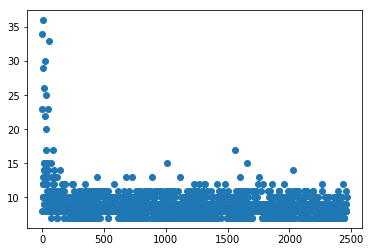

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(len_mem, 'o')

In [91]:
try:
    env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 5000
    for t in count():
        env.render()
        action = get_model_action(model, obs, device, train=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print(t)

63
63


In [49]:
model.to('cpu')

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=8, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)

In [50]:
torch.save(model, 'model.torch')

In [51]:
model = torch.load('model.torch')

In [52]:
model.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=8, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)